In [680]:
from matplotlib import pyplot as plt

import miniflow.op as op    
import miniflow.executor as executor
import numpy as np
from miniflow.node import Node
import importlib
from typing import List

In [681]:
importlib.reload(op)
importlib.reload(executor)

<module 'miniflow.executor' from 'E:\\ASC\\assignment02\\miniflow\\miniflow\\executor.py'>

In [682]:
class MyLinear:
    def __init__(self, input_size, output_size, layer_id,input_node=None):
        self.input_size = input_size
        self.output_size = output_size
        # W: input * output
        
        if input_node is None:
            self.input_node = op.Variable("X")
        else:
            self.input_node = input_node
        self.W = op.Variable(f"W_{layer_id}")
        self.W_val = np.ones((self.input_size, self.output_size))
        self.B = op.Variable(f"B_{layer_id}")
        self.B_val = 0.0
        
        
        self.rst = op.add_op(op.matmul_op(self.input_node, self.W), self.B)
        
        self.forward_executor = executor.Executor([self.rst])
        # -2 W -3 B
        # 标签节点
        #  上一次计算的值
        self.last_rst_val = 0.0
        
    
    def __call__(self, *args, **kwargs):
        return self.forward(*args, **kwargs)
    
    def forward(self, input):
        # input_size: batch * d
        feed_dict = {self.input_node: input, self.W: self.W_val, self.B: self.B_val}
        run_dict = self.forward_executor.run(feed_dict)
        self.last_rst_val = run_dict[-1]
        return run_dict[-1]

In [683]:
class Relu(op.Op):
    def __call__(self, node):
        new_node = op.Op.__call__(self)
        new_node.name = f"relu_{node.name}"
        new_node.inputs = [node]
        return new_node

    def compute(self, node, input_vals):
        return np.maximum(input_vals[0], 0)

    def gradient(self, node, output_grad) -> List[Node]:
        # relu dx = dy dy > 0
        # dx = 0 dy <= 0
        return [relu_op(output_grad)]
    
relu_op = Relu()

relu_op.compute(None, [np.array([1,1,1,1,0,0,1,-1])])

array([1, 1, 1, 1, 0, 0, 1, 0])

In [684]:
class MyMLP:
    def __init__(self, input_size, hidden_size, output_size):
        self.L1 = MyLinear(input_size, hidden_size,1)
        self.rl_node = relu_op(self.L1.rst)
        self.L2 = MyLinear(hidden_size, output_size, 2, input_node=self.rl_node)
        
        self.minus_node = None
        self.loss_node = None
        self.loss_executor = None
        # 反向传播的梯度节点
        self.grad_node_list = None
        # 初始化反向传播执行器，初始化计算图
        self.backward_executor = None
        
        self.need_grad_list = [self.L1.W, self.L1.B, self.L2.W, self.L2.B]
        self.need_grad_val_list = [self.L1.W_val, self.L1.B_val, self.L2.W_val, self.L2.B_val]
        
        
        self.last_rst_val_l2 = 0.0
        self.last_rst_val_l1 = 0.0
        self.last_input = 0.0
        self.last_loss_val = 0.0
        self.last_label = 0.0
    
    def __call__(self, *args, **kwargs):
        return self.forward(*args, **kwargs)    
    
    def forward(self, input):
        self.last_input = input
        
        feed_dict = {self.L1.input_node: input, self.L1.W: self.L1.W_val, self.L1.B: self.L1.B_val,
                    self.L2.W: self.L2.W_val, self.L2.B: self.L2.B_val}
        
        l2_output_val = self.L2.forward_executor.run(feed_dict)[-1]
        self.last_rst_val_l2 = l2_output_val
        return l2_output_val
    
    def compute_loss_and_backward(self, label, lr):
        self.minus_node = op.add_const_op(self.L2.rst, -label)
        if self.loss_node is None:
            self.loss_node = op.matmul_op(self.minus_node, self.minus_node, trans_A=True)
        if self.loss_executor is None:
            self.loss_executor = executor.Executor([self.loss_node])
        # 反向传播的梯度节点
        
        
        
        self.backward_executor = executor.Executor(self.need_grad_list)
        
        self.grad_node_list = executor.gradient(self.loss_node,
                                                   self.need_grad_list)
        # 初始化反向传播执行器，初始化计算图
        self.backward_executor = executor.Executor(self.grad_node_list)
        
        
        feed_dict={self.L1.input_node: self.last_input, self.L1.W: self.L1.W_val, self.L1.B: self.L1.B_val,
                    self.L2.W: self.L2.W_val, self.L2.B: self.L2.B_val}
        self.last_loss_val = self.loss_executor.run(feed_dict)[-1]
        # print(f"loss: {self.last_loss_val}")
        grad_val_list = self.backward_executor.run(feed_dict)
        for i in range(len(self.need_grad_list)):
            self.need_grad_val_list[i] -= (lr * grad_val_list[i])
        return self.last_loss_val
            

        
        

测试正向传播

In [685]:
batch_size = 8
input_size = 3
hidden_size = 16
output_size = 1

mlp = MyMLP(input_size, hidden_size, output_size)
X = np.random.rand(batch_size, input_size)
mlp.forward(X)

array([[37.93954861],
       [29.78724362],
       [35.82946233],
       [21.18634719],
       [23.56892347],
       [22.05488026],
       [12.1501469 ],
       [25.65964492]])

In [686]:
weights = np.array([2.5, -3.0, 1.5])
bias = 0.8
Y = np.dot(X, weights) + bias + np.random.normal(batch_size, output_size)
Y = Y.reshape(-1, 1)

测试反向传播

In [687]:
print(X.shape)
print(Y.shape)

(8, 3)
(8, 1)


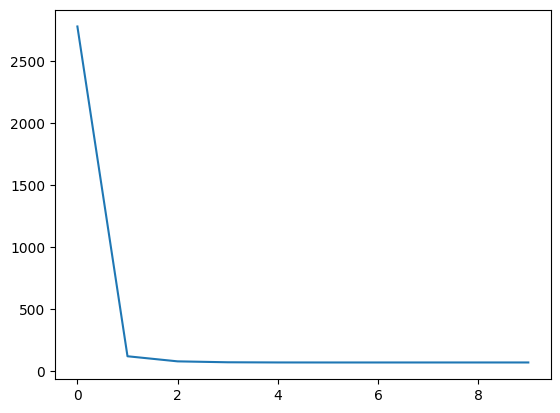

In [688]:
loss_list = []
for i in range(10):
    mlp.forward(X)
    loss_val = mlp.compute_loss_and_backward(Y, 0.001)
    loss_list.append(loss_val.item())
    
plt.plot(loss_list)

In [689]:
print(mlp.forward(X))

[[12.07729124]
 [ 9.35687707]
 [11.46609416]
 [ 6.58822346]
 [ 7.70781536]
 [ 6.99451435]
 [ 3.81650642]
 [ 8.19948346]]
